<a href="https://colab.research.google.com/github/shashankvmaiya/Movie-Genre-Multi-Label-Text-Classification/blob/master/Reports/4_Modeling_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [22]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip3 install --quiet "tensorflow>=1.7"
!pip3 install --quiet tensorflow-hub

In [24]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import functools 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import re
import os.path
import math
from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.cross_validation import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
#from skmultilearn.problem_transform import LabelPowerset
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import scipy

import nltk
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('wordnet')

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

from helper_functions import *
import tensorflow as tf
import tensorflow_hub as hub

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Few relevant functions

In [0]:
def plot_similarity(labels, features, rotation):
  unique_labels = functools.reduce(lambda l, x: l if x in l else l+[x], labels, [])
  corr = np.inner(features, features)
  fig = plt.figure(figsize=(10,10))
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=unique_labels,
      yticklabels=unique_labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(unique_labels, rotation=rotation)
  ticks = np.linspace(len(features)/len(unique_labels)/2, len(features)-len(features)/len(unique_labels)/2, len(unique_labels), dtype=np.int)
  g.set_xticks(ticks)
  g.set_yticks(ticks)
  g.set_title("Semantic Textual Similarity for: {}".format(unique_labels))


def run_and_plot(messages_, labels):
  similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
  similarity_message_encodings = embed(similarity_input_placeholder)
  with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())  
    message_embeddings_ = session.run(similarity_message_encodings, feed_dict={similarity_input_placeholder: messages_})
    plot_similarity(labels, message_embeddings_, 90)

In [0]:
def get_2d_representation(words_list, labels):
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        description_embeddings  =  session.run(embed(words_list)) #Generates the sentence embeddings
        
        model = PCA(n_components = 2) # Initializing the PCA object. We use n_components = 2 to help us plot our findings in the 2D space.
        # Apply the fit_transform method of model to grains: pca_features
        pca_features = model.fit_transform(description_embeddings) # Transforms embeddings to vectors of size 2
        # Assign 0th column of pca_features: xs
        xs = pca_features[:,0] #The first component of PCA
        # Assign 1st column of pca_features: ys
        ys = pca_features[:,1] #Second component of PCA
        
        #Next, we'll plot these results
        tmp = {}
        label_idx = [tmp.setdefault(name, len(tmp)) for name in labels]
        unique_labels = functools.reduce(lambda l, x: l if x in l else l+[x], labels, [])
        df = pd.DataFrame({'x':xs, 'y': ys, 'label':label_idx})
        colors = ['r', 'b', 'g', 'm', 'k']
        
        fig, ax = plt.subplots(figsize=(10,10)) 
        for idx in range(len(set(labels))):
          ax.scatter(df[df['label']==idx].x, df[df['label']==idx].y, c=colors[idx], label=unique_labels[idx])
        
        ax.set(title='PCA Representation for Genres: {}'.format(unique_labels))
        ax.legend()

# MODELING

**Loading the input**

In [0]:
#mydata_train = pd.read_csv('./../Data/preprocessed/movies_genres_train_preprocessed.csv')
#mydata_test = pd.read_csv('./../Data/preprocessed/movies_genres_test_preprocessed.csv')
#mydata = pd.read_csv('../Data/movies_genres.csv', delimiter='\t')

mydata_train = pd.read_csv('gdrive/My Drive/Colab Notebooks/Data/preprocessed/movies_genres_train_preprocessed.csv')
mydata_test = pd.read_csv('gdrive/My Drive/Colab Notebooks/Data/preprocessed/movies_genres_test_preprocessed.csv')
mydata = pd.read_csv('gdrive/My Drive/Colab Notebooks/Data/movies_genres.csv', delimiter='\t')

In [0]:
train_X, train_y = mydata_train['plot'], mydata_train.drop(['title', 'plot', 'plot_lang'], axis=1)
test_X, test_y = mydata_test['plot'], mydata_test.drop(['title', 'plot', 'plot_lang'], axis=1)

category_columns = train_y.columns

In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url)

## Obtain Plot Embedding

In [0]:
with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  chunk_size = 1000
  num_chunks = math.ceil()train_X.shape[0]/chunk_size)
  train_X_vector = np.array()
  for idx in range(num_chunks):
    train_X_vector  =  session.run(embed(list(train_X))) #Generates the sentence embeddings

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0313 21:48:26.365500 140097885337472 saver.py:1483] Saver not created because there are no variables in the graph to restore


## Visualizing Plot Similarities
Let us pick plots from few genres and see how this universal sentence encoder embeds them into vectors

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0313 21:28:15.498656 140097885337472 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0313 21:29:00.110974 140097885337472 saver.py:1483] Saver not created because there are no variables in the graph to restore


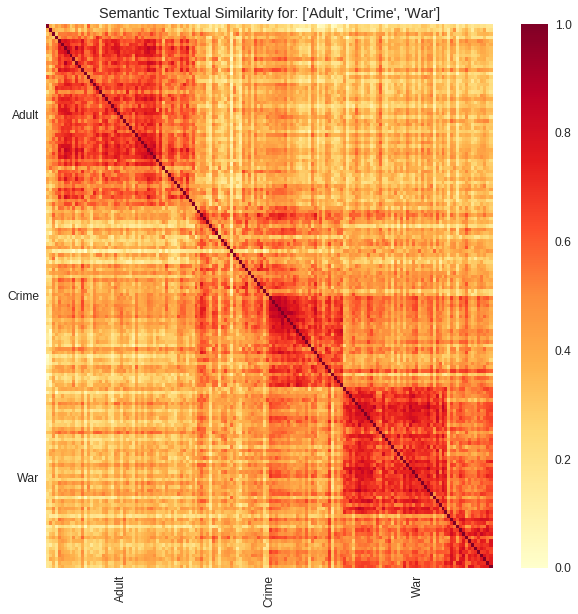

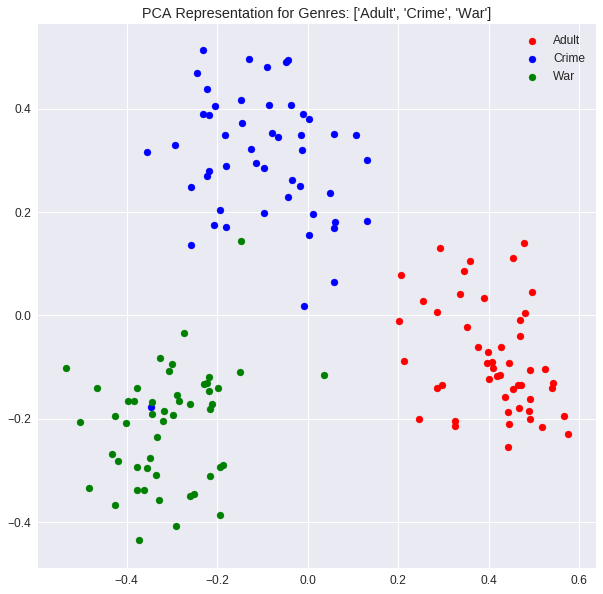

In [119]:
genre_list = ['Adult', 'Crime', 'War']
plot_inp = []
genre_inp = []
for genre in genre_list:
  plot_inp+=(list(train_X[train_y[genre]==1].iloc[:50]))
  genre_inp+=[genre]*50

run_and_plot(plot_inp, genre_inp) 
get_2d_representation(plot_inp, genre_inp)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0313 21:36:10.752347 140097885337472 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0313 21:37:04.791071 140097885337472 saver.py:1483] Saver not created because there are no variables in the graph to restore


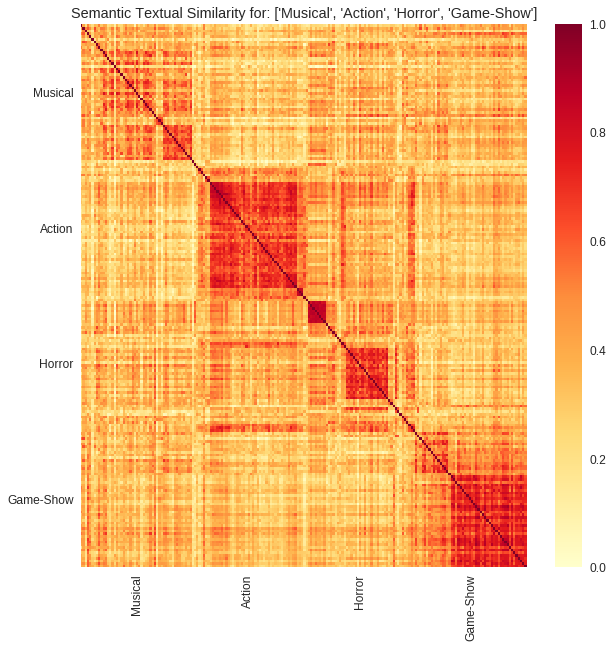

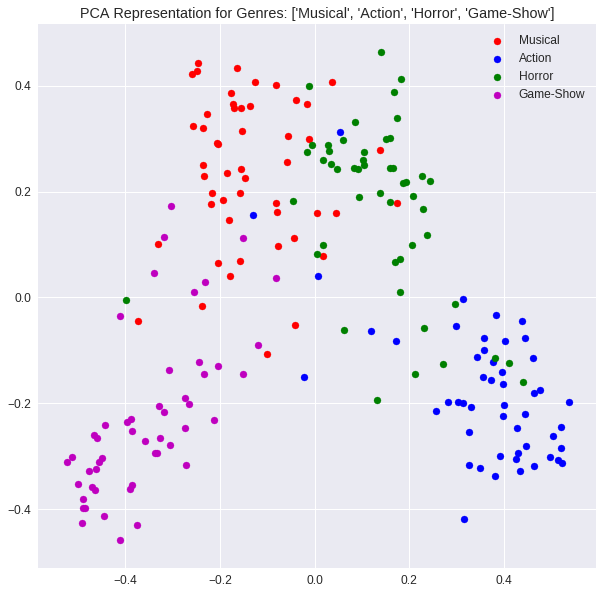

In [122]:
genre_list = ['Musical', 'Action', 'Horror', 'Game-Show']
plot_inp = []
genre_inp = []
for genre in genre_list:
  plot_inp+=(list(train_X[train_y[genre]==1].iloc[:50]))
  genre_inp+=[genre]*50

run_and_plot(plot_inp, genre_inp) 
get_2d_representation(plot_inp, genre_inp)

## Plot Embedding

In [129]:
with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  description_embeddings  =  session.run(embed(list(train_X.iloc[:50]))) #Generates the sentence embeddings

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0313 21:43:06.813874 140097885337472 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [131]:
type(description_embeddings)

numpy.ndarray